In [1]:
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.tsa.api as smtsa
import os

### Citation:

#### Board of Governors of the Federal Reserve System (US), Industrial Production:<br/>Nondurable Goods: Sugar and confectionery product [IPG3113N], retrieved from FRED,<br/>Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/IPG3113N, October 13, 2017.

In [ ]:
os.chdir("Time_Series_Data/")

In [2]:
with zipfile.ZipFile("us-candy-production-by-month.zip") as zf:
    zf.printdir()
    zf.extractall()

File Name                                             Modified             Size
candy_production.csv                           2017-10-13 20:41:18        10740


In [3]:
pd.set_option("display.notebook_repr_html", False)
pd.set_option("display.max_rows", 30)

In [4]:
data = pd.read_csv("candy_production.csv", parse_dates=["observation_date"])

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548 entries, 0 to 547
Data columns (total 2 columns):
observation_date    548 non-null datetime64[ns]
IPG3113N            548 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 8.6 KB


In [6]:
data.observation_date = pd.to_datetime(data.observation_date)
data.head()

  observation_date  IPG3113N
0       1972-01-01   85.6945
1       1972-02-01   71.8200
2       1972-03-01   66.0229
3       1972-04-01   64.5645
4       1972-05-01   65.0100

In [7]:
df = data.copy()
df.index = data.observation_date

In [8]:
df.rename(columns={"IPG3113N": "Production"}, inplace=True)
df.head()

                 observation_date  Production
observation_date                             
1972-01-01             1972-01-01     85.6945
1972-02-01             1972-02-01     71.8200
1972-03-01             1972-03-01     66.0229
1972-04-01             1972-04-01     64.5645
1972-05-01             1972-05-01     65.0100

In [9]:
df.index.name = "Date"

In [10]:
df.head()

           observation_date  Production
Date                                   
1972-01-01       1972-01-01     85.6945
1972-02-01       1972-02-01     71.8200
1972-03-01       1972-03-01     66.0229
1972-04-01       1972-04-01     64.5645
1972-05-01       1972-05-01     65.0100

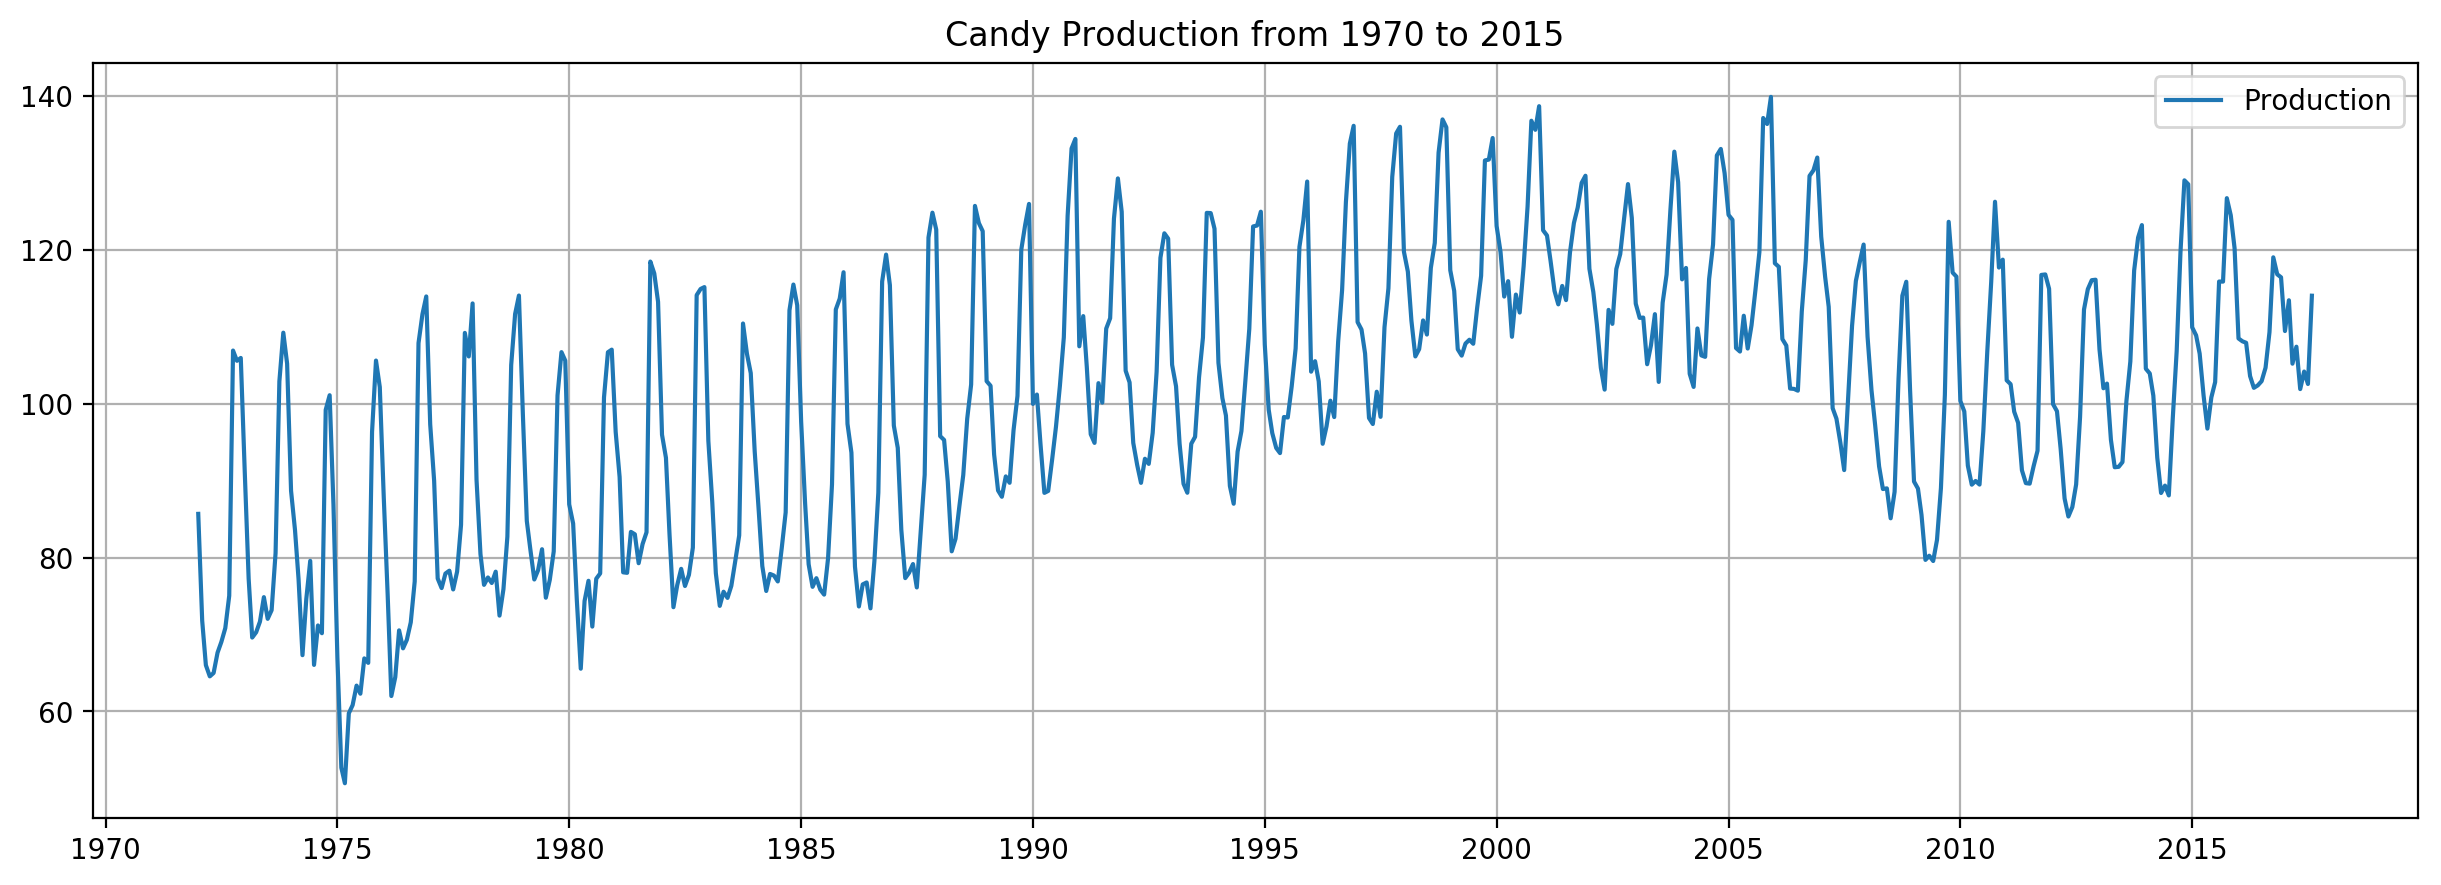

In [12]:
plt.figure(figsize=(15,5), dpi=200)

plt.plot(df.Production, label="Production")

plt.title("Candy Production from 1970 to 2015")
plt.grid()
plt.legend()
plt.show();

#### Series appears to be has a nonlinear trend with independent seasonality.

In [43]:
def stationary(data, alpha=0.05):
    adf = smtsa.adfuller(data, autolag="AIC")
    if adf[1] > alpha:
        return f"P-value: {adf[1]:.2f}; Series is non-stationary." 
    return f"P-value: {adf[1]:.2f}; Series is stationary."

In [44]:
stationary(df.Production)

'P-value: 0.34; Series is non-stationary.'

#### Does MA smooth the series ?

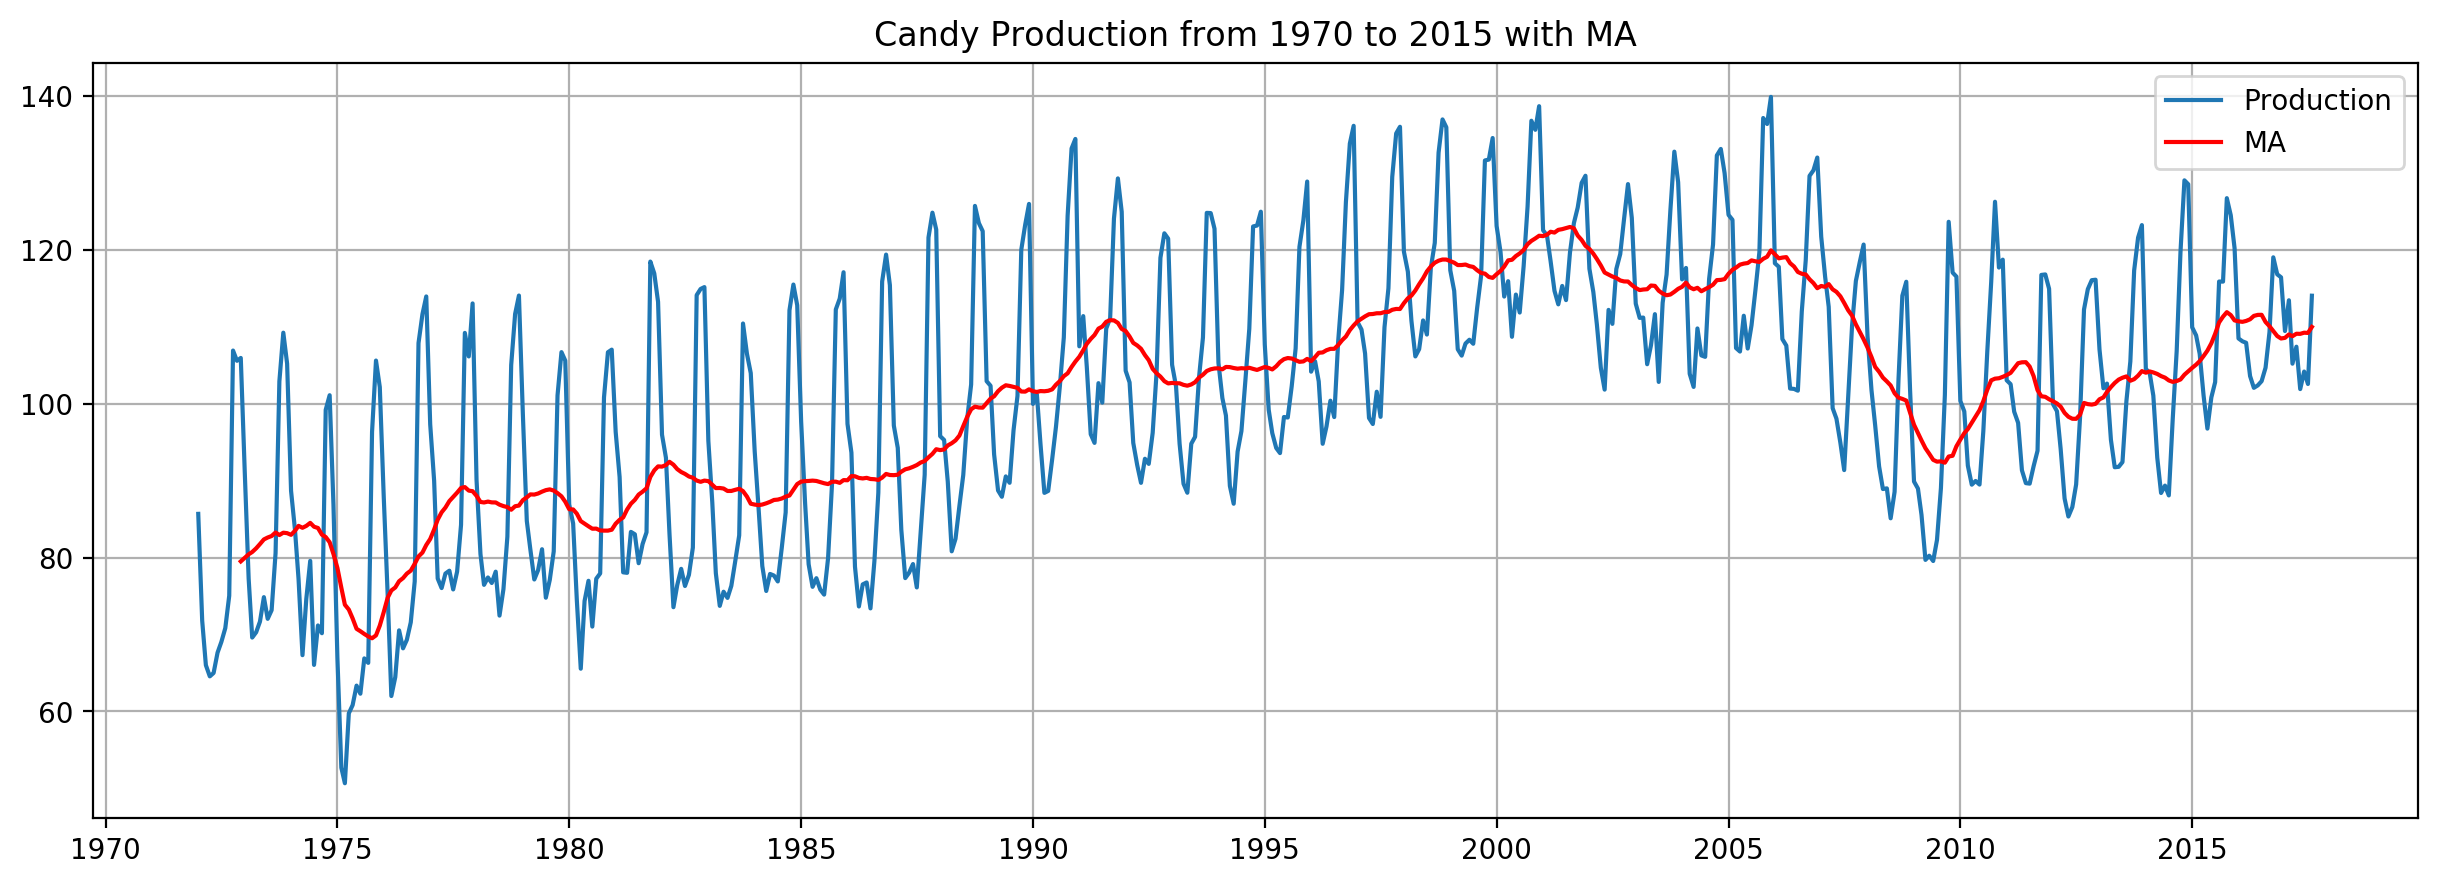

In [27]:
plt.figure(figsize=(15,5), dpi=200)

plt.plot(df.Production, label="Production")

plt.plot(df.Production.rolling(12).mean(), color="r", label="MA")
plt.title("Candy Production from 1970 to 2015 with MA")

plt.grid()
plt.legend()
plt.show();

#### The moving average smoothes the series. Try the ARMA model.

### Verify Autocorrelation

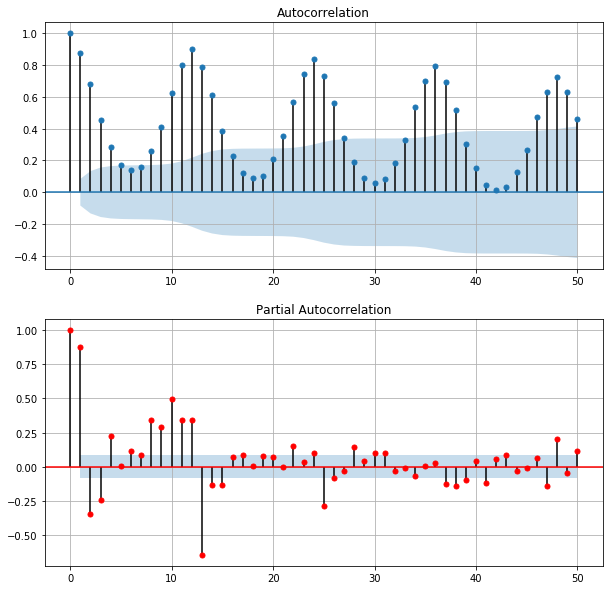

In [33]:
f, ax = plt.subplots(2, figsize=(10,10))

plot_acf(df.Production, ax=ax[0], lags=50)

plot_pacf(df.Production, ax=ax[1], lags=50, color="r")

ax[0].grid()
ax[1].grid()

plt.show();

#### For the  Autocorrelation figure  :
#### Small lags are positive, statistically significant.
#### Correlation between larger lags show seasonality.

#### Grid seatch for ARMA parameters.

In [17]:
arma = smtsa.ARMA(df.Production, order=min_aic).fit(maxlag=50, method="mle", trend="c")

/Users/Dominance/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [30]:
def minimal_aic(val):
    "return minimal AIC values"
    best_aic = {}
    for i in range(1, 3):
        for j in range(0, 3):
            arma_values = smtsa.ARMA(val.tolist(), order=(i, j)).fit(maxlag=50, method="mle", trend="c")
            best_aic[(i, j)] = [arma_values.aic]
    return min(best_aic.keys(), key=(lambda k: best_aic[k]))  

In [31]:
min_aic = minimal_aic(df.Production)
min_aic

(2, 2)

In [20]:
df["ARMA"] = arma.predict()
df.head()

           observation_date  Production        ARMA
Date                                               
1972-01-01       1972-01-01     85.6945  100.754157
1972-02-01       1972-02-01     71.8200   87.559812
1972-03-01       1972-03-01     66.0229   71.884492
1972-04-01       1972-04-01     64.5645   68.398925
1972-05-01       1972-05-01     65.0100   71.290263

#### Predict Candy production using ARMA.

In [21]:
arma.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:             Production   No. Observations:                  548
Model:                     ARMA(2, 2)   Log Likelihood               -1905.908
Method:                           mle   S.D. of innovations              7.824
Date:                Mon, 22 Jul 2019   AIC                           3823.816
Time:                        19:49:00   BIC                           3849.653
Sample:                    01-01-1972   HQIC                          3833.914
                         - 08-01-2017                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              100.7542      1.995     50.515      0.000      96.845     104.663
ar.L1.Production     0.8538      0.116      7.374      0.000       0.627       1.081
ar.L2.Production    -0.1359      0.101     -1.345      0.179      -0.334       0.062
ma.L1.Production     0.2891      0.108      2.672      0.008       0.077       0.501
ma.L2.Production     0.4026      0.054      7.414      0.000       0.296       0.509
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.5571           +0.0000j            1.5571            0.0000
AR.2            4.7257           +0.0000j            4.7257            0.0000
MA.1           -0.3590           -1.5345j            1.5759           -0.2866
MA.2           -0.3590           +1.5345j            1.5759            0.2866
-----------------------------------------------------------------------------
"""

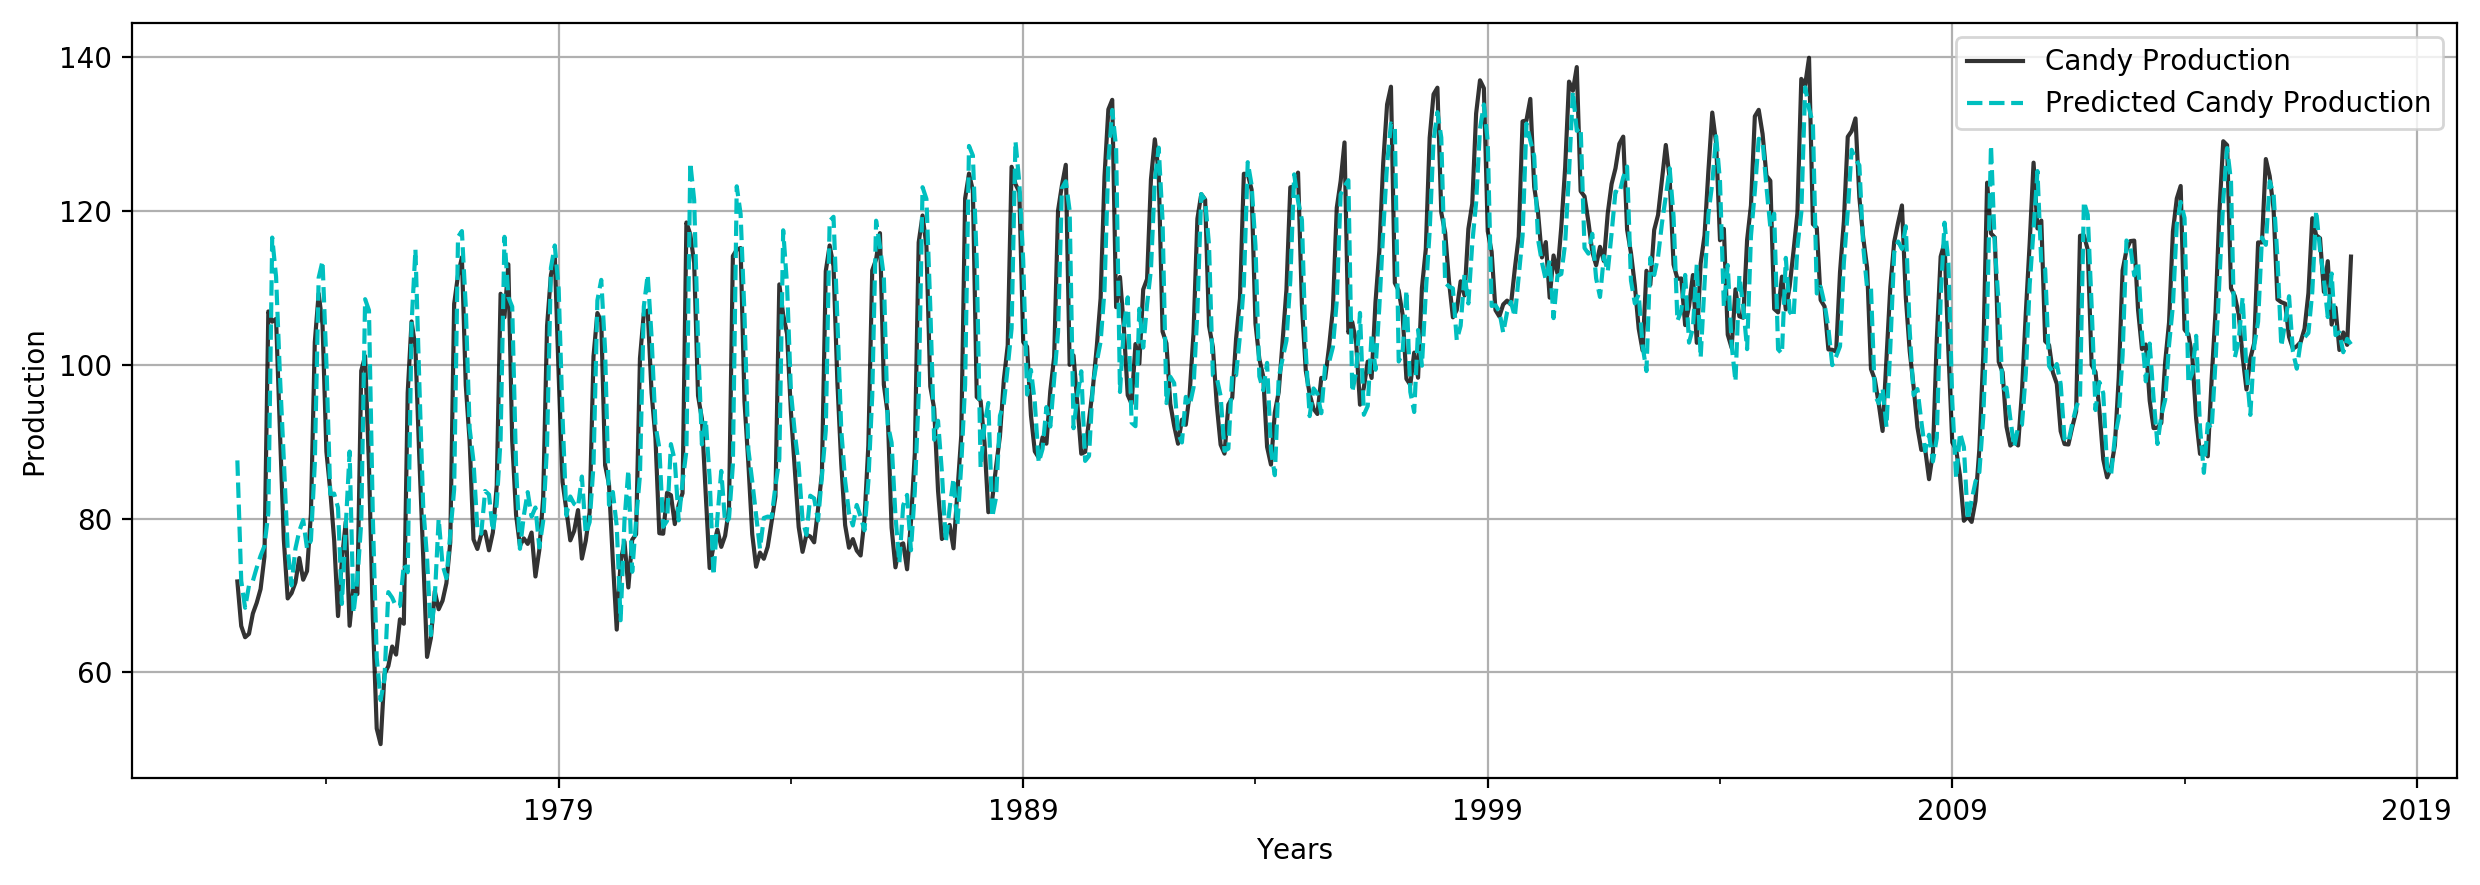

In [45]:
f, ax = plt.subplots(1, figsize=(15,5), dpi=200)

df.Production.iloc[1:].plot(label="Candy Production", color="k", alpha=0.8)

df.ARMA.iloc[1:].plot(color="c", label="Predicted Candy Production", ls="--")

plt.xlabel("Years")
plt.ylabel("Production")

plt.grid()
plt.legend()
plt.show();


#### A decent fit of the predicted values but this model did stationarize the series while making its prediction.